In [175]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import platform
import seaborn as sns
import os

In [176]:
os.getcwd()

'/Users/chance/Desktop/LH_home/ksc'

In [190]:
folder = os.listdir()

file = []
for f in folder:
    if "jinju" in f:
        data = pd.read_csv("./" + f, encoding="cp949", skiprows=15)
        data = data[list(data.columns[:11])]
        file.append(data)

gajwa = pd.concat(file)
# gajwa = gajwa.dropna(axis=0)

In [191]:
gajwa.도로조건.value_counts()

8m미만     1797
-        1581
12m미만    1454
25m미만     384
25m이상      55
Name: 도로조건, dtype: int64

In [192]:
geo = pd.read_csv("./geocoding.csv")
gajwa["경도"] = geo.X
gajwa["위도"] = geo.Y

gajwa = gajwa.fillna({'건축년도':gajwa['건축년도'].mode()[0]})
gajwa = gajwa.fillna({'도로명':gajwa['도로명'].mode()[0]})
gajwa = gajwa.fillna({'도로조건':gajwa['도로조건'].mode()[0]})

# 도로조건을 정수로 변환
road=[]
for a in gajwa["도로조건"]:
    if a=="-":
        a = "8"
    if a=="25m이상":
        a = "30"
    road.append(int(a.split("m")[0]))
gajwa["도로조건"] = road


# 년월 column 생성
year=[]
month=[]
for d in gajwa["계약년월"]:
    day = pd.to_datetime(d, format="%Y%m")
    year.append(day.year)
    month.append(day.month)

gajwa["year"] = year
gajwa["month"] = month

built_day = [pd.to_datetime(d, format="%Y").year for d in gajwa["건축년도"]]
gajwa["건축년도"] = built_day

# 위치 column만들기
gajwa["location"] = gajwa.시군구 + " " + gajwa.도로명

# 계약년월 기준으로 전월세전환율 입력하기
rate = pd.read_csv("./rate.csv", encoding="cp949")
rate = rate.T
rate = rate[3:]

month = []
for r in rate.index:
    new = "".join(r.split("."))
    month.append(int(new))

rate["계약년월"] = month
rate.columns = ["전월세전환율", "계약년월"]
rate.head()

gajwa = pd.merge(left=gajwa, right=rate, how="inner", on="계약년월")

keep = [int("".join(k.split(","))) for k in gajwa["보증금(만원)"]]
gajwa["보증금(만원)"] = keep


# 전월세전환율 기준으로 보증금+월세의 가치를 전세로 치환하여 value column으로 만들어준다.
value=[round(gajwa["월세(만원)"][i] * 12 / (gajwa["전월세전환율"][i]/100) + gajwa["보증금(만원)"][i]) for i in range(len(gajwa))]
gajwa["전세전환가격"] = value
#gajwa["도로별 전세값평균"] = gajwa.groupby("도로명").전세전환가격.transform("mean")


# 도로명 결측치 제거
indexNames = []
for i in range(len(gajwa["도로명"])):
    if "번길" not in gajwa["도로명"][i]:
        indexNames.append(i)

gajwa.drop(indexNames, inplace=True)


gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735
3,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000
4,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000
5,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,21,5000,0,2019,진주대로404번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 진주대로404번길,5.1,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5251,경상남도 진주시 호탄동,6**,12,33.00,월세,202011,19,100,23,2002,호탄길21번길,128.104882,35.150661,2020,11,경상남도 진주시 호탄동 호탄길21번길,4.7,5972
5253,경상남도 진주시 호탄동,6**,8,42.90,전세,202011,25,7500,0,2018,호탄길9번길,128.115149,35.162316,2020,11,경상남도 진주시 호탄동 호탄길9번길,4.7,7500
5254,경상남도 진주시 호탄동,9**,12,50.00,월세,202011,10,5000,30,2011,가호로61번길,128.103328,35.145290,2020,11,경상남도 진주시 호탄동 가호로61번길,4.7,12660
5255,경상남도 진주시 호탄동,6**,8,50.00,전세,202011,18,9000,0,2018,호탄길9번길,128.105966,35.156961,2020,11,경상남도 진주시 호탄동 호탄길9번길,4.7,9000


## 지도

In [193]:
import math as m

def distance(x1, x2, y1, y2):
    radius = 6371 # 지구 반지름(km)
    toRadian = m.pi / 180

    deltaLatitude = abs(x1 - x2) * toRadian
    deltaLongitude = abs(y1 - y2) * toRadian

    sinDeltaLat = m.sin(deltaLatitude / 2)
    sinDeltaLng = m.sin(deltaLongitude / 2)
    squareRoot = m.sqrt(sinDeltaLat * sinDeltaLat + m.cos(x1 * toRadian) * m.cos(x2 * toRadian) * sinDeltaLng * sinDeltaLng)

    distance = 2 * radius * m.asin(squareRoot)

    return distance

In [194]:
gnu_lat = 35.1530444
gnu_long = 128.1010899

gnu_dist = []
for long, lat in zip(gajwa["경도"], gajwa["위도"]):
    d = distance(gnu_lat, lat, gnu_long, long)
    gnu_dist.append(d)
gajwa["gnu_distance"] = gnu_dist

## 데이터 시각화

In [200]:
def remove_out(dataframe, remove_col):
    dff = dataframe
    for k in remove_col:
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.7)
        IQR = level_3q - level_1q
        rev_range = 3  # 제거 범위 조절 변수
        dff = dff[(dff[k] <= level_3q + (rev_range * IQR)) & (dff[k] >= level_1q - (rev_range * IQR))]
        dff = dff.reset_index(drop=True)
    return dff

gajwa = remove_out(gajwa, ["계약면적(㎡)", "전세전환가격", "gnu_distance"])

gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격,gnu_distance,area
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,0.657356,후문
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,0.734594,후문
2,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,0.796668,후문
3,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,0.796668,후문
4,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,21,5000,0,2019,진주대로404번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 진주대로404번길,5.1,5000,0.796668,후문
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,경상남도 진주시 호탄동,6**,8,33.00,월세,202011,16,1000,40,2016,호탄길34번길,128.102026,35.149158,2020,11,경상남도 진주시 호탄동 호탄길34번길,4.7,11213,0.440456,남문
3668,경상남도 진주시 호탄동,6**,12,33.00,월세,202011,19,100,23,2002,호탄길21번길,128.104882,35.150661,2020,11,경상남도 진주시 호탄동 호탄길21번길,4.7,5972,0.434847,남문
3669,경상남도 진주시 호탄동,6**,8,42.90,전세,202011,25,7500,0,2018,호탄길9번길,128.115149,35.162316,2020,11,경상남도 진주시 호탄동 호탄길9번길,4.7,7500,1.642123,호탄
3670,경상남도 진주시 호탄동,9**,12,50.00,월세,202011,10,5000,30,2011,가호로61번길,128.103328,35.145290,2020,11,경상남도 진주시 호탄동 가호로61번길,4.7,12660,0.885957,그 외


In [201]:
gajwa.corr()

,도로조건,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,경도,위도,year,month,전세전환가격,gnu_distance
도로조건,1.000000,-0.009395,0.200662,0.011400,-0.067877,0.098283,-0.000541,0.020749,-0.004055,0.200020,0.041573,0.187150,0.036361
계약면적(㎡),-0.009395,1.000000,-0.134834,-0.020330,0.097258,0.128436,-0.156867,0.105081,-0.083652,-0.135505,0.053001,0.225890,0.194145
계약년월,0.200662,-0.134834,1.000000,-0.016124,-0.020526,-0.002683,0.185056,0.046375,0.010758,0.999907,-0.020727,0.354495,0.098914
계약일,0.011400,-0.020330,-0.016124,1.000000,-0.006518,-0.003296,0.026475,0.004564,-0.008887,-0.016974,0.062909,-0.014468,-0.018443
보증금(만원),-0.067877,0.097258,-0.020526,-0.006518,1.000000,-0.835910,0.060498,0.037039,0.005335,-0.021309,0.058038,-0.438411,0.030447
월세(만원),0.098283,0.128436,-0.002683,-0.003296,-0.835910,1.000000,0.038984,-0.002338,-0.026251,-0.001926,-0.055525,0.785963,0.030136
건축년도,-0.000541,-0.156867,0.185056,0.026475,0.060498,0.038984,1.000000,-0.010086,-0.007658,0.185027,-0.002953,0.163856,0.018190
경도,0.020749,0.105081,0.046375,0.004564,0.037039,-0.002338,-0.010086,1.000000,0.546759,0.046057,0.022071,0.038426,0.574123
위도,-0.004055,-0.083652,0.010758,-0.008887,0.005335,-0.026251,-0.007658,0.546759,1.000000,0.010543,0.015509,-0.029516,0.381665
year,0.200020,-0.135505,0.999907,-0.016974,-0.021309,-0.001926,0.185027,0.046057,0.010543,1.000000,-0.034338,0.354557,0.098913


In [202]:
area = []

for long, lat in zip(gajwa["경도"],gajwa["위도"]) :
    if 128.102554 < long < 128.107094 and 35.155823 < lat < 35.162156 :
        area.append('후문')
    elif 128.107502 < long < 128.116019 and 35.155877 < lat < 35.158884 :
        area.append('경찰서')
    elif 128.105510 < long < 128.109887 and 35.152340 < lat <35.155835 :
        area.append('정문')
    elif 128.099328 < long < 128.105970 and 35.14718 < lat < 35.151686 :
        area.append('남문')
    elif 128.102356 < long < 128.118509 and 35.161807 < lat < 35.166844 :
        area.append('호탄')
    elif 128.107524 < long < 128.118378 and 35.159442 < lat < 35.161644 :
        area.append('호탄')
    else :
        area.append('그 외')

gajwa["area"] = area
gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격,gnu_distance,area
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,0.657356,후문
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,0.734594,후문
2,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,0.796668,후문
3,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,0.796668,후문
4,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,21,5000,0,2019,진주대로404번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 진주대로404번길,5.1,5000,0.796668,후문
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,경상남도 진주시 호탄동,6**,8,33.00,월세,202011,16,1000,40,2016,호탄길34번길,128.102026,35.149158,2020,11,경상남도 진주시 호탄동 호탄길34번길,4.7,11213,0.440456,남문
3668,경상남도 진주시 호탄동,6**,12,33.00,월세,202011,19,100,23,2002,호탄길21번길,128.104882,35.150661,2020,11,경상남도 진주시 호탄동 호탄길21번길,4.7,5972,0.434847,남문
3669,경상남도 진주시 호탄동,6**,8,42.90,전세,202011,25,7500,0,2018,호탄길9번길,128.115149,35.162316,2020,11,경상남도 진주시 호탄동 호탄길9번길,4.7,7500,1.642123,호탄
3670,경상남도 진주시 호탄동,9**,12,50.00,월세,202011,10,5000,30,2011,가호로61번길,128.103328,35.145290,2020,11,경상남도 진주시 호탄동 가호로61번길,4.7,12660,0.885957,그 외


In [203]:
gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격,gnu_distance,area
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,0.657356,후문
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,0.734594,후문
2,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,0.796668,후문
3,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,0.796668,후문
4,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,21,5000,0,2019,진주대로404번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 진주대로404번길,5.1,5000,0.796668,후문
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,경상남도 진주시 호탄동,6**,8,33.00,월세,202011,16,1000,40,2016,호탄길34번길,128.102026,35.149158,2020,11,경상남도 진주시 호탄동 호탄길34번길,4.7,11213,0.440456,남문
3668,경상남도 진주시 호탄동,6**,12,33.00,월세,202011,19,100,23,2002,호탄길21번길,128.104882,35.150661,2020,11,경상남도 진주시 호탄동 호탄길21번길,4.7,5972,0.434847,남문
3669,경상남도 진주시 호탄동,6**,8,42.90,전세,202011,25,7500,0,2018,호탄길9번길,128.115149,35.162316,2020,11,경상남도 진주시 호탄동 호탄길9번길,4.7,7500,1.642123,호탄
3670,경상남도 진주시 호탄동,9**,12,50.00,월세,202011,10,5000,30,2011,가호로61번길,128.103328,35.145290,2020,11,경상남도 진주시 호탄동 가호로61번길,4.7,12660,0.885957,그 외


<AxesSubplot:xlabel='계약면적(㎡)', ylabel='전세전환가격'>

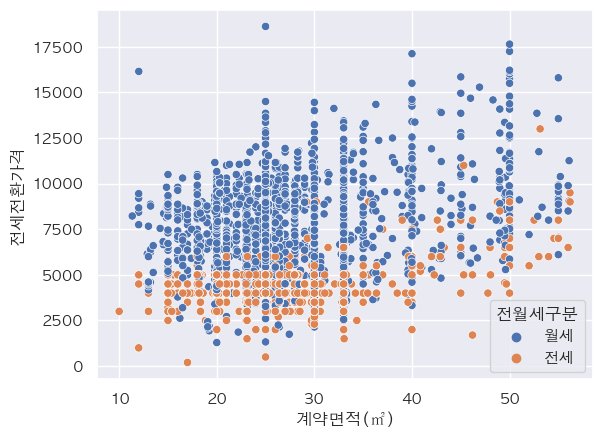

In [211]:
sns.scatterplot(data = gajwa, x = "계약면적(㎡)", y = "전세전환가격", hue="전월세구분")

<AxesSubplot:xlabel='계약년월', ylabel='전세전환가격'>

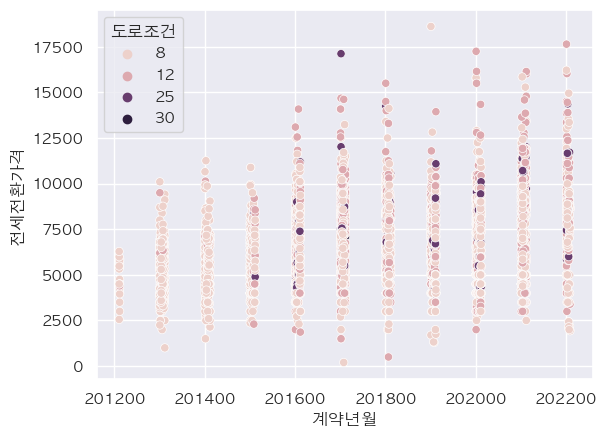

In [213]:
sns.scatterplot(data = gajwa, x = "계약년월", y = "전세전환가격", hue = "도로조건")

In [154]:
# import folium

# m = folium.Map(location=[gnu_lat, gnu_long], zoom_start=14)

# for lo, la, in zip(gajwa.경도, gajwa.위도):
#     folium.Marker([la, lo]).add_to(m)

# m

In [155]:
# m = folium.Map(location=[gajwa.위도.max(),gajwa.경도.min()], zoom_start=16)
# folium.Marker([gajwa.위도.max(),gajwa.경도.min()]).add_to(m)
# m

In [156]:
# # 전세 월세 구분 데이터셋
# gajwa = gajwa[gajwa.전월세구분 == "월세"]
# gajwa = pd.DataFrame.drop(gajwa, columns=["전월세구분"], axis=1)

#원핫인코딩
gajwa = pd.get_dummies(gajwa, columns = ["전월세구분", "area"])

gajwa

,시군구,번지,도로조건,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,...,전세전환가격,gnu_distance,전월세구분_월세,전월세구분_전세,area_경찰서,area_그 외,area_남문,area_정문,area_호탄,area_후문
0,경상남도 진주시 가좌동,1***,25,12.00,201902,16,200,35,2016,가좌길74번길,...,8435,0.657356,1,0,0,0,0,0,0,1
1,경상남도 진주시 가좌동,1***,12,14.85,201902,20,500,35,2019,가좌길64번길,...,8735,0.734594,1,0,0,0,0,0,0,1
2,경상남도 진주시 가좌동,1***,8,16.00,201902,20,3000,0,2016,가좌길48번길,...,3000,0.796668,0,1,0,0,0,0,0,1
3,경상남도 진주시 가좌동,1***,8,18.00,201902,20,5000,0,2016,가좌길44번길,...,5000,0.796668,0,1,0,0,0,0,0,1
4,경상남도 진주시 가좌동,1***,8,18.00,201902,21,5000,0,2019,진주대로404번길,...,5000,0.796668,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,경상남도 진주시 호탄동,6**,8,33.00,202011,16,1000,40,2016,호탄길34번길,...,11213,0.440456,1,0,0,0,1,0,0,0
3668,경상남도 진주시 호탄동,6**,12,33.00,202011,19,100,23,2002,호탄길21번길,...,5972,0.434847,1,0,0,0,1,0,0,0
3669,경상남도 진주시 호탄동,6**,8,42.90,202011,25,7500,0,2018,호탄길9번길,...,7500,1.642123,0,1,0,0,0,0,1,0
3670,경상남도 진주시 호탄동,9**,12,50.00,202011,10,5000,30,2011,가호로61번길,...,12660,0.885957,1,0,0,1,0,0,0,0


In [157]:
gajwa_data = pd.DataFrame.drop(gajwa, columns=["시군구","계약년월", "번지", "도로명", "계약일", "보증금(만원)", "월세(만원)", "location", "경도", "위도", "전월세전환율", "gnu_distance"], axis=1)

#gajwa_data.distance = gajwa_data.distance.transform(lambda x: (x - x.mean()) / x.std())
#gajwa_data.전세전환가격 = gajwa_data.전세전환가격.transform(lambda x: (x - x.mean()) / x.std())
gajwa_data

,도로조건,계약면적(㎡),건축년도,year,month,전세전환가격,전월세구분_월세,전월세구분_전세,area_경찰서,area_그 외,area_남문,area_정문,area_호탄,area_후문
0,25,12.00,2016,2019,2,8435,1,0,0,0,0,0,0,1
1,12,14.85,2019,2019,2,8735,1,0,0,0,0,0,0,1
2,8,16.00,2016,2019,2,3000,0,1,0,0,0,0,0,1
3,8,18.00,2016,2019,2,5000,0,1,0,0,0,0,0,1
4,8,18.00,2019,2019,2,5000,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,8,33.00,2016,2020,11,11213,1,0,0,0,1,0,0,0
3668,12,33.00,2002,2020,11,5972,1,0,0,0,1,0,0,0
3669,8,42.90,2018,2020,11,7500,0,1,0,0,0,0,1,0
3670,12,50.00,2011,2020,11,12660,1,0,0,1,0,0,0,0


# 머신러닝

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import catboost
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [159]:
X = gajwa_data.drop(["전세전환가격"], axis=1)
y = gajwa_data['전세전환가격']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1645)

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

# minmaxScaler = MinMaxScaler()
# X_train_standardized2 = minmaxScaler.fit_transform(X_train)
# X_test_standardized2 = minmaxScaler.fit_transform(X_test)

## 선형회귀분석

In [160]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_preds = lr.predict(X_test)

# mse = mean_squared_error(y_test, y_preds)
# rmse = np.sqrt(mse)

# print(f"MSE : {mse:.3f}", f"RMSE: {rmse:.3f}")
# print(f"variance score : {r2_score(y_test, y_preds):.3f}")

In [161]:
# lr.fit(X_train_standardized, y_train)
# lr.score(X_test_standardized, y_test)

## Ridge

In [162]:
# R_model = Ridge()
# R_model.fit(X_train, y_train)
# print(R_model.score(X_test, y_test))

# R_model.fit(X_train_standardized, y_train)
# R_model.score(X_test_standardized, y_test)

## Lasso

In [163]:
# L_model = Lasso(alpha=0.5)
# L_model.fit(X_train, y_train)
# print(L_model.score(X_test, y_test))

# L_model.fit(X_train_standardized, y_train)
# L_model.score(X_test_standardized, y_test)

## ElasticNet

In [164]:
# ela = ElasticNet(alpha=0.5)
# ela.fit(X_train, y_train)
# print(ela.score(X_test, y_test))

# ela.fit(X_train_standardized, y_train)
# ela.score(X_test_standardized, y_test)

## 랜덤포레스트

In [165]:
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)
randomforest_model = randomforest.fit(X_train, y_train)
print(randomforest_model.score(X_test, y_test))

randomforest_model = randomforest.fit(X_train_standardized, y_train)
print(randomforest_model.score(X_test_standardized, y_test))

0.6251278566713634
0.6220859101341787


In [166]:
gbm = GradientBoostingRegressor()

gbm.fit(X_train, y_train)
print(gbm.score(X_test, y_test))

gbm.fit(X_train_standardized, y_train)
print(gbm.score(X_test_standardized, y_test))

0.652981292955688
0.6487212128300553


## LightGBM

In [167]:
lightgbm = lgb.LGBMRegressor()

lightgbm.fit(X_train, y_train)
print(lightgbm.score(X_test, y_test))

lightgbm.fit(X_train_standardized, y_train)
print(lightgbm.score(X_test_standardized, y_test))

0.6539189230877422
0.6429106828754517


## XGBoost

In [168]:
xgboost = XGBRegressor(n_estimators=50)
xgboost.fit(X_train, y_train)
print(xgboost.score(X_test, y_test))

xgboost.fit(X_train_standardized, y_train)
xgboost.score(X_test_standardized, y_test)

0.6293593314734113


/Users/chance/opt/anaconda3/envs/py3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.6097147521407381

## CatBoost

In [169]:
cb = catboost.CatBoostRegressor()
cb.fit(X_train_standardized, y_train)
cb.score(X_test_standardized, y_test)

Learning rate set to 0.048541
0:	learn: 2358.3946325	total: 1.74ms	remaining: 1.74s
1:	learn: 2295.5669744	total: 2.71ms	remaining: 1.35s
2:	learn: 2237.8148257	total: 3.33ms	remaining: 1.11s
3:	learn: 2186.0869795	total: 4.03ms	remaining: 1s
4:	learn: 2136.0794195	total: 4.96ms	remaining: 988ms
5:	learn: 2088.3589077	total: 6.11ms	remaining: 1.01s
6:	learn: 2048.0706480	total: 6.74ms	remaining: 956ms
7:	learn: 2006.0029956	total: 7.43ms	remaining: 922ms
8:	learn: 1969.7660323	total: 8.13ms	remaining: 895ms
9:	learn: 1933.7531499	total: 8.88ms	remaining: 879ms
10:	learn: 1901.1199121	total: 9.64ms	remaining: 867ms
11:	learn: 1868.4427838	total: 10.6ms	remaining: 869ms
12:	learn: 1841.5202284	total: 10.9ms	remaining: 830ms
13:	learn: 1814.6736419	total: 11.9ms	remaining: 835ms
14:	learn: 1790.2413248	total: 12.8ms	remaining: 841ms
15:	learn: 1767.0426145	total: 14.1ms	remaining: 868ms
16:	learn: 1745.3734400	total: 15.5ms	remaining: 898ms
17:	learn: 1724.4652645	total: 16.5ms	remaining:

0.6443421224106184

In [170]:
gajwa_data.corr()

,도로조건,계약면적(㎡),건축년도,year,month,전세전환가격,전월세구분_월세,전월세구분_전세,area_경찰서,area_그 외,area_남문,area_정문,area_호탄,area_후문
도로조건,1.000000,-0.009395,-0.000541,0.200020,0.041573,0.187150,0.064700,-0.064700,-0.002996,0.002102,0.003280,-0.008257,0.042278,-0.017298
계약면적(㎡),-0.009395,1.000000,-0.156867,-0.135505,0.053001,0.225890,0.056781,-0.056781,0.054510,0.127917,0.027765,0.055744,0.186213,-0.263526
건축년도,-0.000541,-0.156867,1.000000,0.185027,-0.002953,0.163856,-0.015920,0.015920,-0.016415,0.034545,-0.032874,-0.011682,-0.001020,0.014455
year,0.200020,-0.135505,0.185027,1.000000,-0.034338,0.354557,-0.027367,0.027367,0.006704,0.032067,-0.016866,-0.018980,0.110482,-0.054754
month,0.041573,0.053001,-0.002953,-0.034338,1.000000,-0.014327,-0.037576,0.037576,-0.010090,-0.031939,0.010879,0.015753,0.011989,0.002941
전세전환가격,0.187150,0.225890,0.163856,0.354557,-0.014327,1.000000,0.588515,-0.588515,0.012788,0.059617,-0.007808,0.006132,0.094161,-0.092595
전월세구분_월세,0.064700,0.056781,-0.015920,-0.027367,-0.037576,0.588515,1.000000,-1.000000,0.008087,0.009192,-0.006145,-0.010808,-0.014843,0.008738
전월세구분_전세,-0.064700,-0.056781,0.015920,0.027367,0.037576,-0.588515,-1.000000,1.000000,-0.008087,-0.009192,0.006145,0.010808,0.014843,-0.008738
area_경찰서,-0.002996,0.054510,-0.016415,0.006704,-0.010090,0.012788,0.008087,-0.008087,1.000000,-0.099312,-0.096898,-0.095792,-0.062514,-0.223650
area_그 외,0.002102,0.127917,0.034545,0.032067,-0.031939,0.059617,0.009192,-0.009192,-0.099312,1.000000,-0.165308,-0.163422,-0.106648,-0.381547


## HyperParameter

In [171]:
lightgbm.fit(X_train, y_train)
print(lightgbm.score(X_test, y_test))

0.6539189230877422
